# Reference


Tensorflow
1. https://www.tensorflow.org/tutorials/images/classification
2. https://www.tensorflow.org/tutorials/load_data/images
3. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
4. https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

Keras (https://keras.io/api/)
1. https://keras.io/examples/vision/image_classification_from_scratch/
2. https://keras.io/guides/preprocessing_layers/

Data_loading >> https://keras.io/api/data_loading/image/
1. image_dataset_from_directory function = Generates a tf.data.Dataset from image files in a directory. (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
2. load_img function = Loads an image into PIL format.
3. img_to_array function = Converts a PIL Image instance to a Numpy array.
4. save_img function = Saves an image stored as a Numpy array to a path or file object.


Keras models accept three types of inputs:
- NumPy arrays
- TensorFlow Dataset objects
- Python generators

# 1.Setup

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-77726314-02a7-d006-af3c-145110c8df25)


In [2]:
import sys
print(f"Python {sys.version}\n")

import numpy as np
print(f"Numpy {np.__version__}\n")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detected {len(gpus)} GPU(s):")
for i,gpu in enumerate(gpus):
  print(f"...GPU No.{i} : Name = {gpu.name}, Type = {gpu.device_type}")

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

Numpy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
...GPU No.0 : Name = /physical_device:GPU:0, Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
#np.random.seed(1234)
#tf.random.set_seed(1234)
seed = np.random.randint(1000,10000)

In [4]:
batch_size = 32
image_size = (224, 224) # Default of input_shape is 224x224x3 for VGG-16

# 2.Load data using a Keras utility

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class.
# Otherwise, the directory structure is ignored.
train_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/train_ds"
test_dir = "/content/gdrive/MyDrive/DADS_7202/dataset/test_ds"

In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="validation",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 70 files for validation.


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  seed=seed,
  validation_split=0.2,
  subset="training",
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 354 files belonging to 4 classes.
Using 284 files for training.


In [12]:
class_names = train_ds.class_names
print(class_names)

['apple', 'huawei', 'oppo', 'samsung']


# 2.1 Explore train_ds

In [13]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [15]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [16]:
# check dtypes and shape
for images, labels in train_ds.take(1):
  print(f"image = {images.dtype}, shape = {images.shape}")
  print(f"labels = {labels.dtype}, shape = {labels.shape}")

image = <dtype: 'float32'>, shape = (32, 224, 224, 3)
labels = <dtype: 'int32'>, shape = (32,)


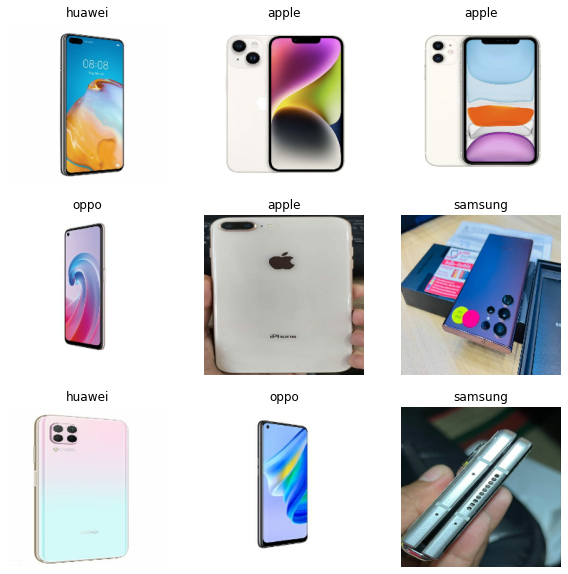

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Creates a Dataset with most count = 1 batch >> 32 elements
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 3.Load the pretrained model (only the feature extractor)

In [18]:
# https://keras.io/api/applications/resnet/#resnet152v2-function
img_w,img_h = 224,224 
ResNet_extractor = tf.keras.applications.ResNet152V2(weights = "imagenet", include_top=False,input_shape = (img_w, img_h,3)) 

#ResNet_extractor.summary()

234545216/234545216 [==============================] - 2s 0us/step


# 4.Tuning Feature Extraction layer

In [19]:
# All layer = False
ResNet_extractor.trainable = False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet_extractor.layers))


Number of layers in the base model:  564


In [20]:
# Fine-tune from this layer onwards
start_from = 130
 # conv4 130
 # covv5 528
for layer in ResNet_extractor.layers[start_from:]:
  layer.trainable = True

In [21]:
# recheck layer.trainable

#for i,layer in enumerate(ResNet_extractor.layers):  
#    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

#4.1 Data Augment

In [22]:
dataaug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip'),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant', name='rand_trans'),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='constant', name='rand_rot')
    ], name='dataaug' )

#4.2 Construct

In [23]:
input_3channel = (224, 224, 3)     

input_dim = input_3channel         # choose the target dimension for this example
output_dim = 4                     # the number of output classes (single-label multi-class classification)   

In [24]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [25]:
# Input layer
inputs = tf.keras.Input(shape=input_dim)


# Data augment
x = dataaug(inputs)
x = preprocess_input(x)


# Feature Extraction
x = ResNet_extractor(x)


# Flatten layer
x = tf.keras.layers.Flatten()(x)


# Classifier
x = tf.keras.layers.Dense(2048, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2048, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)


# Output layer 
outputs = tf.keras.layers.Dense(output_dim, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 dataaug (Sequential)        (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0     

# 5.Compile and train the model

In [27]:
initial_learning_rate = 0.0001 # Defaults to 0.001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
    )

In [28]:
#%cd "/content/gdrive/MyDrive/DADS_7202/ResNet152V2"
#%cd /content/
#%pwd
#%ls

In [29]:
#tf.keras.utils.plot_model(model, to_file='ResNet152V2_sequential.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=150)

In [30]:
checkpoint_filepath = "bestmodel_epoch.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False, 
                                                               monitor='val_acc', 
                                                               mode='max',
                                                               save_best_only=True)

In [31]:
%%time
history = model.fit(
    train_ds,
    epochs=30,
    verbose=1,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback]
    )

CPU times: user 2min 49s, sys: 47.3 s, total: 3min 37s
Wall time: 5min 54s


In [32]:
# Check the keys in 'history'
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

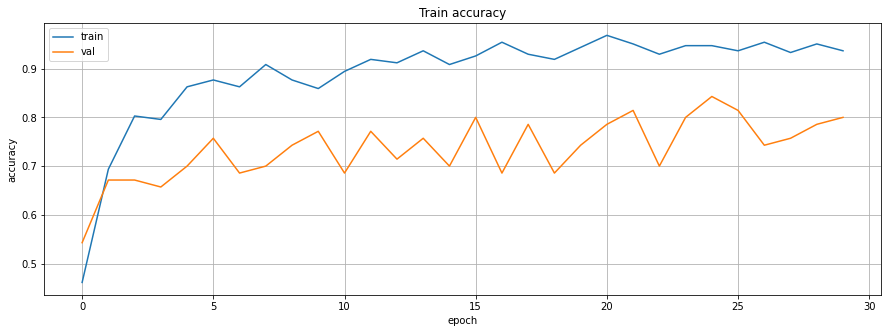

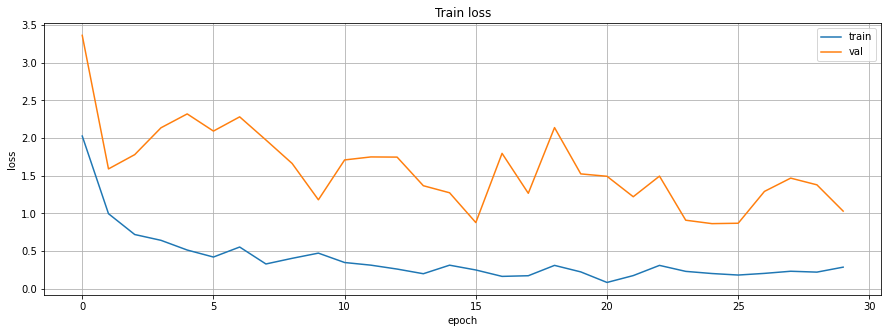

In [33]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# 6.Evaluate the model

In [35]:
# Load test_dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int', # if label_mode is int, the labels are an int32 tensor of shape (batch_size,)
  class_names=None, # otherwise alphanumerical order is used
  color_mode='rgb',
  batch_size=batch_size,
  image_size=image_size,
  shuffle=True,
  interpolation='bilinear',
  follow_links=False,
  crop_to_aspect_ratio=False
  )

Found 80 files belonging to 4 classes.


In [36]:
# Load the model from the best epoch (minimum val_loss)
import os
bestmodel_path = max( [ f for f in os.listdir(".") if f.startswith('bestmodel_epoch') and f.endswith(".hdf5") ] )

model_best = tf.keras.models.load_model(bestmodel_path, compile=True )
print( f"The best model: {bestmodel_path}" )

The best model: bestmodel_epoch.hdf5


In [37]:
# Evaluate the model from the last epoch
results = model.evaluate(test_ds)
print( f"Test results from last model:{model.metrics_names}: {results}\n" )

# Evaluate the model from the best epoch
results_best = model_best.evaluate(test_ds)
print( f"Test results from best model: {model_best.metrics_names}: {results_best}" )


3/3 [==============================] - 15s 509ms/step - loss: 0.7510 - acc: 0.8000
Test results from last model:['loss', 'acc']: [0.7510091066360474, 0.800000011920929]

3/3 [==============================] - 3s 174ms/step - loss: 0.8679 - acc: 0.7750
Test results from best model: ['loss', 'acc']: [0.8679419755935669, 0.7749999761581421]


#7.Inference

In [38]:
# Retrieve a batch of images from the test set
image_batch,label_batch  = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) # Returns predictions for a single batch of samples.


In [39]:
predictions.shape

(32, 4)

In [40]:
print (type(image_batch),", dtype=",image_batch.dtype,", shape=",image_batch.shape)
print (type(label_batch ),", dtype=",label_batch .dtype,", shape=",label_batch .shape)

<class 'numpy.ndarray'> , dtype= float32 , shape= (32, 224, 224, 3)
<class 'numpy.ndarray'> , dtype= int32 , shape= (32,)


In [41]:
for i in range(10):
  print("No.", i, 'Labels:', class_names[label_batch[i]], 'Predictions:', class_names[np.argmax(predictions[i])])

No. 0 Labels: huawei Predictions: oppo
No. 1 Labels: samsung Predictions: oppo
No. 2 Labels: huawei Predictions: huawei
No. 3 Labels: apple Predictions: huawei
No. 4 Labels: samsung Predictions: samsung
No. 5 Labels: samsung Predictions: samsung
No. 6 Labels: oppo Predictions: oppo
No. 7 Labels: huawei Predictions: huawei
No. 8 Labels: samsung Predictions: huawei
No. 9 Labels: huawei Predictions: huawei


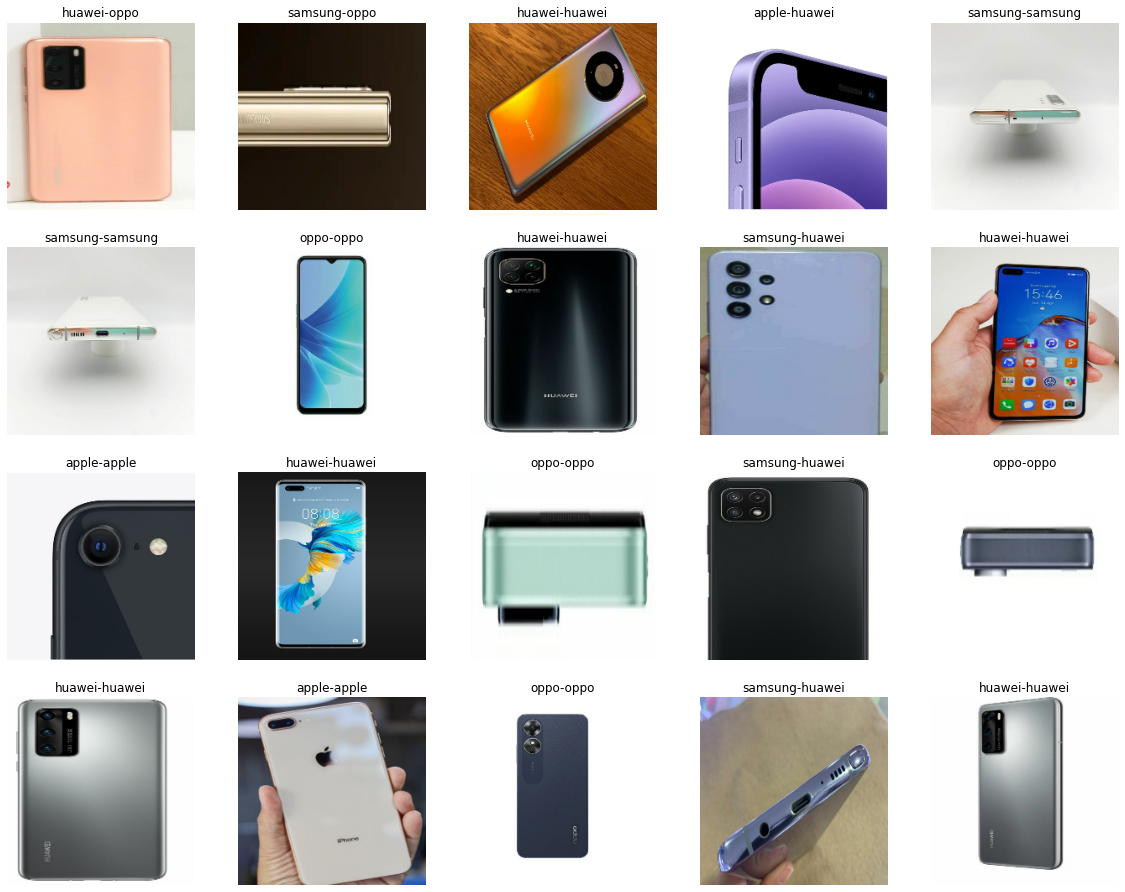

In [42]:
plt.figure(figsize=(20, 20))

for i in range(20):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title( class_names[label_batch[i]] + "-" +class_names[np.argmax(predictions[i])] )  # y_test y_pred
  plt.axis("off")